## Interpolation with seasonal decomposition

As linear interpolation principle of work is just to join known values with straight lines I decided to try one more approach.\
Data I worked with were time series describing vital signs of a patient observed for multiple days an recorded at on average hourly basis, therefore I could expect that some periodical trends may appear. (It might have happened for example if some parameters revealed a tendency to vary depending on a part of a day or because of periodical medical staff changes that happened each day at 7 am and might have influenced child's calmness)

To handle that I decided to:
1. at first perform seasonal decomposition of each time series
2. extract the established seasonal component
3. perform linear interpolation on deseasonalised time series
4. recreate time series adding extracted seasonal component.

I modeled on the example described in https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7 (section "Seasonal Trend Decomposition using Loess (STL) Imputation")

Before I could perform seasonal decomposition I needed to establish constant time step for each time series. From the previous work I knew that record were taken either at full hour or at half-hour (half-hour time step precision was the highest). Therefore I decided to populate the data with empty rows so that i had a record every half an hour. I then used 48-sample period (corresponding to 24 hours) when decomposing series. After interpolation I reduced the dataset to achieve records taken on constant hourly-basis.

This approach should have be modified If I decided to make used of CVP data (recording of which was stopped during patients observation). It was however interesting to compare how the two of interpolation methods would handle extrapolating data for such a big period of time.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

In [11]:
df = pd.read_csv('../../data/df.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_lin_int = pd.read_csv('../../data/df_linearly_interpolated.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')

In [12]:
class DecompositionMonster:
    def __init__(self, param, df_to_interpolate):
        self.param = param
        self.series_decomposed = []
        self.missing_values_indieces = []
        self.df_stl_int = df_to_interpolate.copy()
        self.df_lin_int = df_to_interpolate.interpolate(method='linear')
    
    def decompose(self, period=24):
        self.missing_values_indieces = df_to_interpolate[df_to_interpolate[self.param].isnull()].index
        
        stl = STL(self.df_lin_int[self.param], period=period, seasonal=7)
        self.series_decomposed = stl.fit()
        self.series_decomposed.plot()
        
    def stl_interpolate(self):
        seasonal_component = self.series_decomposed.seasonal
        # seasonal_component.isna().sum()
        series_deseasonalised = df_to_interpolate[self.param] - seasonal_component
        series_deseasonalised_interpolated = series_deseasonalised.interpolate(method="linear")
        series_interpolated = series_deseasonalised_interpolated + seasonal_component
    
        # self.df_stl_int.loc[self.missing_values_indieces, self.param] = series_interpolated[self.missing_values_indieces]
        self.df_stl_int[self.param] = series_interpolated

    def comparison_plot_both(self):
        plt.figure(figsize=[12, 6])
        self.df_stl_int[self.param].plot(style='-', alpha=.5, color='red', label='STL series')
        self.df_lin_int[self.param].plot(style='-', alpha=.5, color='b', label='linear series')

        max_val = max(*self.df_stl_int.loc[self.missing_values_indieces, self.param], *self.df_lin_int.loc[self.missing_values_indieces, self.param])
        min_val = min(*self.df_stl_int.loc[self.missing_values_indieces, self.param], *self.df_lin_int.loc[self.missing_values_indieces, self.param])
        treshold = (max_val - min_val)/100
        significant_diff_indices = []
        for i in self.missing_values_indieces:
            int_difference = abs(self.df_stl_int.loc[i, self.param] - self.df_lin_int.loc[i, self.param])
            if int_difference > treshold:
                significant_diff_indices.append(i)

        plt.scatter(significant_diff_indices, self.df_stl_int.loc[significant_diff_indices, self.param], color='red', s=12, label='STL filled values')
        plt.scatter(significant_diff_indices, self.df_lin_int.loc[significant_diff_indices, self.param], color='b', s=12, label='linear filled values')
        # plt.scatter(self.missing_values_indieces, self.df_stl_int.loc[self.missing_values_indieces, self.param], color='red', s=12, label='STL filled values')
        # plt.scatter(self.missing_values_indieces, self.df_lin_int.loc[self.missing_values_indieces, self.param], color='b', s=12, label='linear filled values')
        
        plt.title(self.param + " - STL and linear interpolation comparison")
        plt.ylabel(self.param)
        plt.xlabel("Time")
        plt.legend()
        plt.show()

    # def comparison_plot_stl_only(self):
    #     plt.figure(figsize=[12, 6])
    #     self.df_stl_int[self.param].plot(style='-', alpha=.5, color='red', label='STL series')
    #     plt.scatter(self.missing_values_indieces, self.df_stl_int.loc[self.missing_values_indieces, self.param], color='red', s=12 , label='STL filled values')
    #     plt.scatter(self.missing_values_indieces, self.df_lin_int.loc[self.missing_values_indieces, self.param], color='b', label='linear filled values')
        
    #     plt.title(self.param + " - STL and linear interpolation comparison")
    #     plt.ylabel(self.param)
    #     plt.xlabel("Time")
    #     plt.legend()
    #     plt.show()

## seasonal decomp + interpolation with prior addition of empty rows so that records took place each 30 mins

I compared interpolation results using linear and STL approach in plots below. I only used markers where filled values differed by more then 1/100 series' values range

In [13]:
for date in df.set_index('date').index:
    if not (str(date)[14:] == '00:00' or str(date)[14:] == '30:00'):
        print(str(date)[14:])

45:00


In [14]:
temp_df = df.set_index('date')
for date in temp_df.index:
    if str(date)[14:] == '45:00':
        print(temp_df.loc[date])

pulse             140.0
RR_systolic        85.0
RR_diastolic       50.0
saturation_pct      NaN
CVP_average        14.0
breaths_forced      NaN
breaths_all         NaN
Name: 2023-11-17 06:45:00, dtype: float64


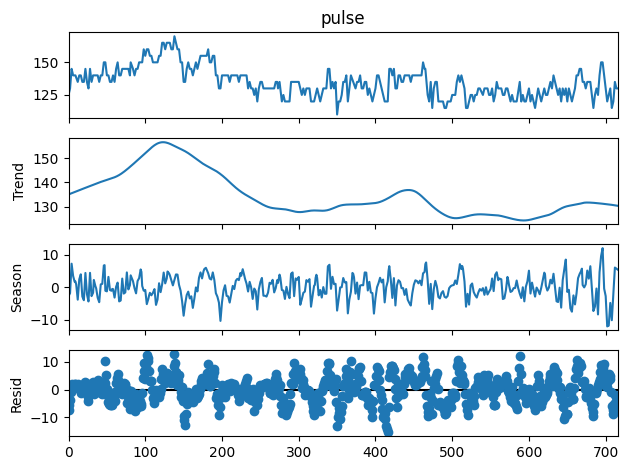

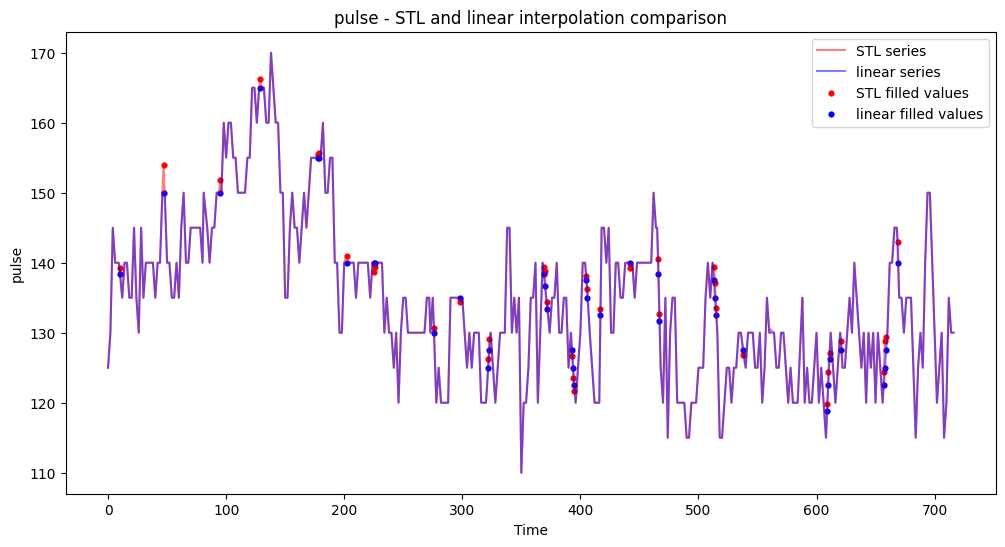

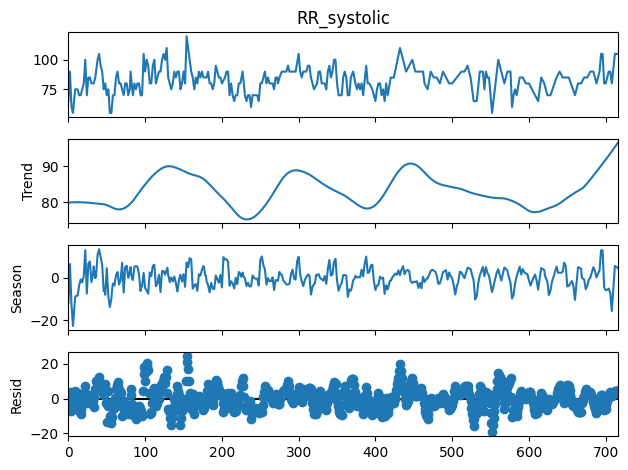

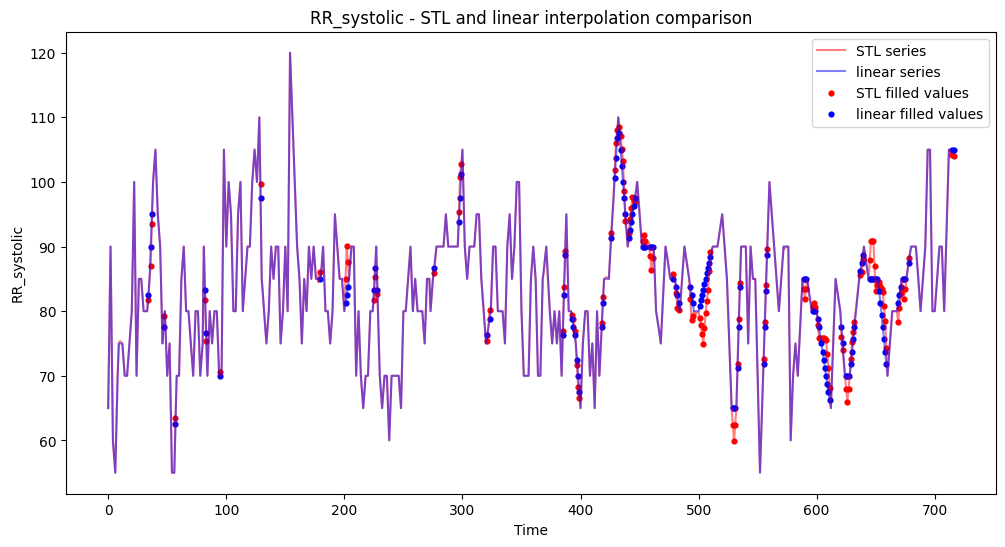

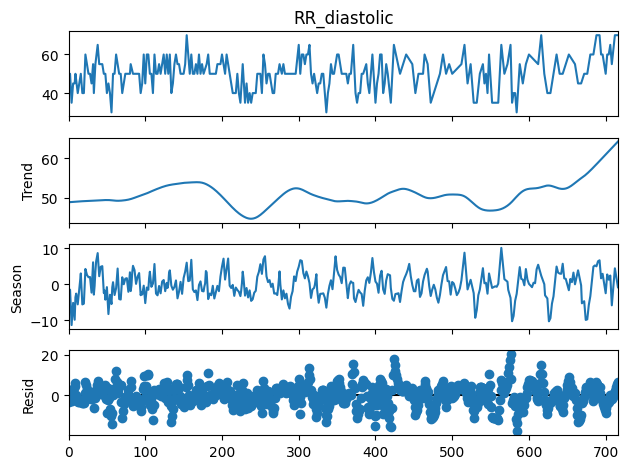

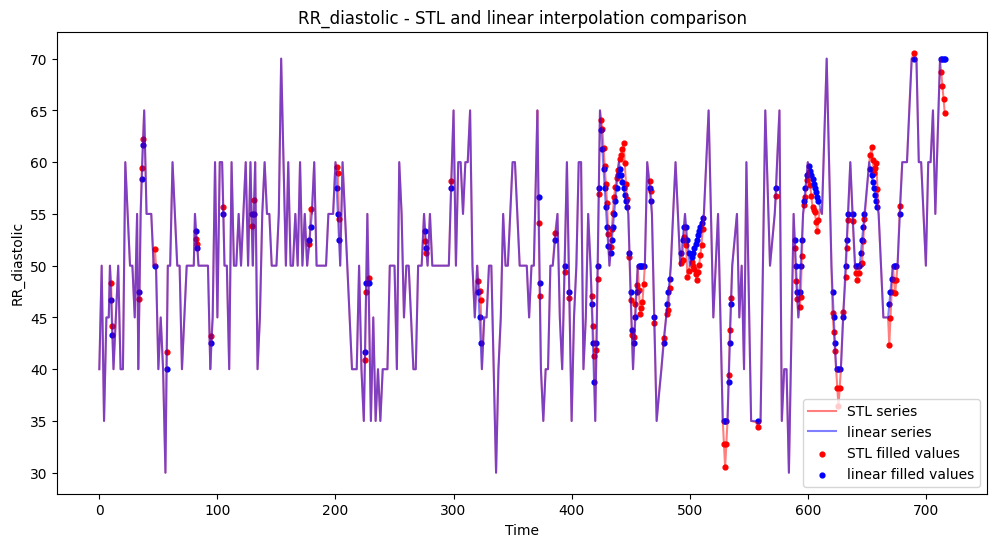

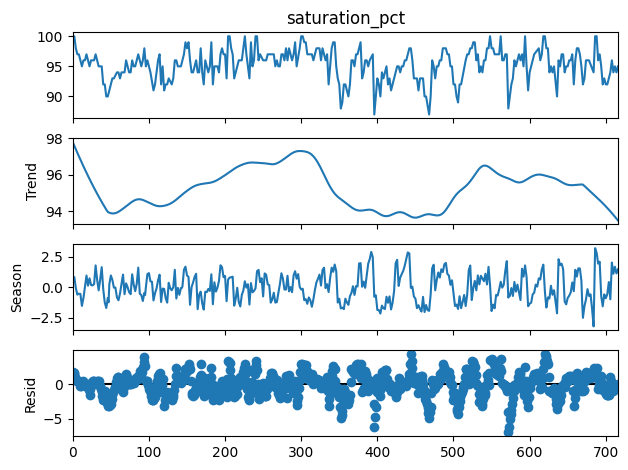

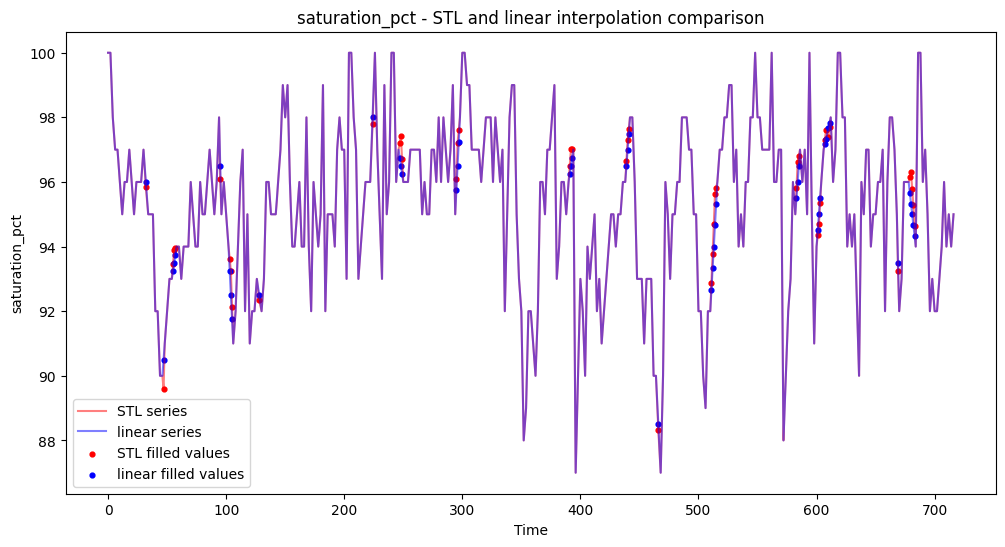

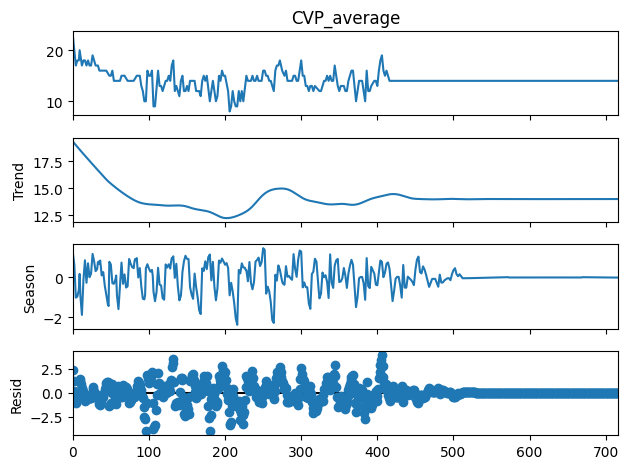

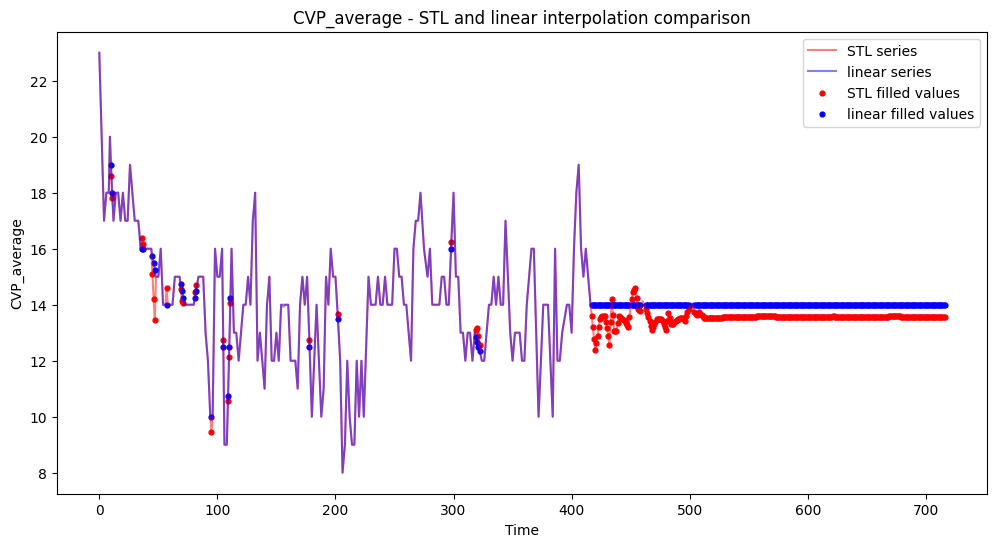

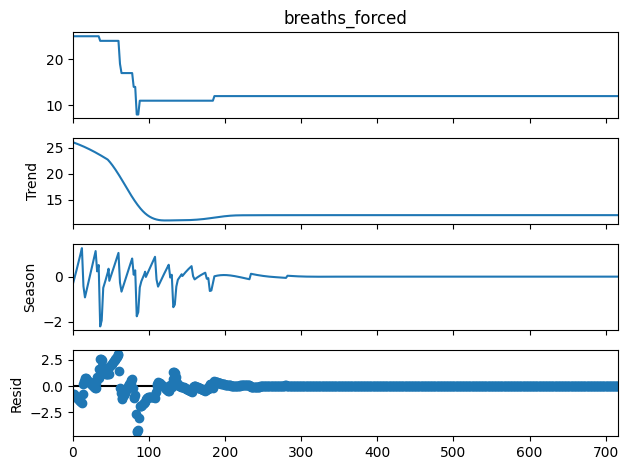

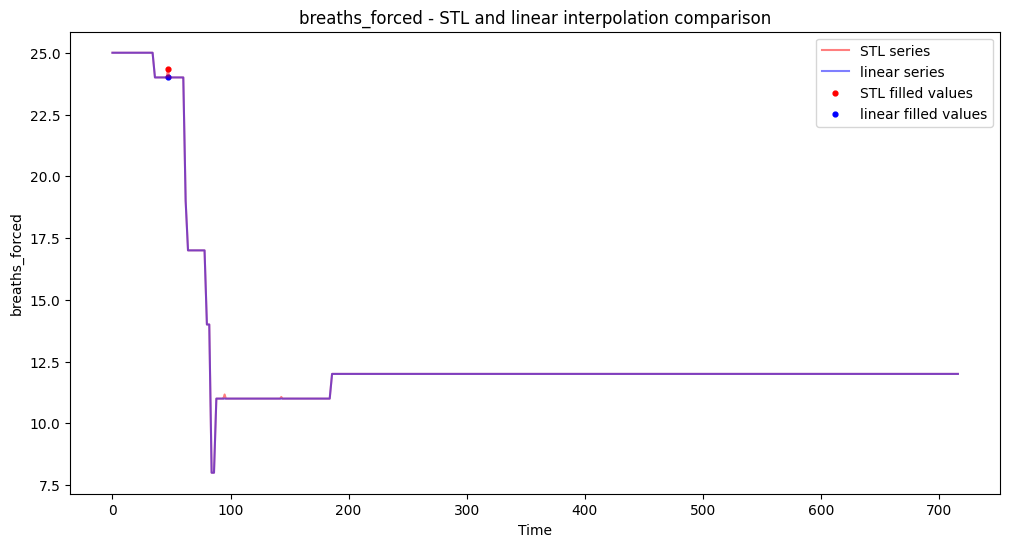

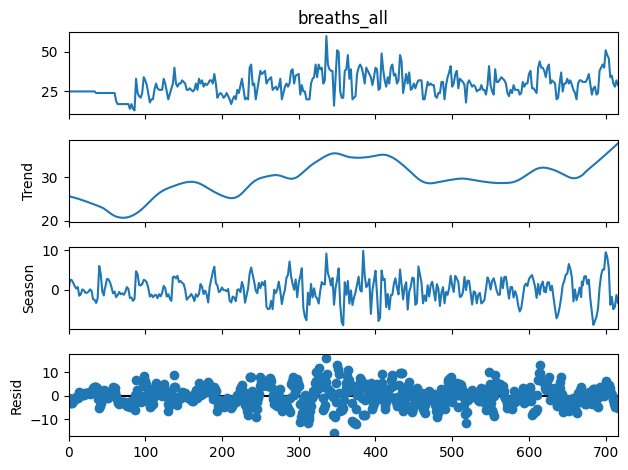

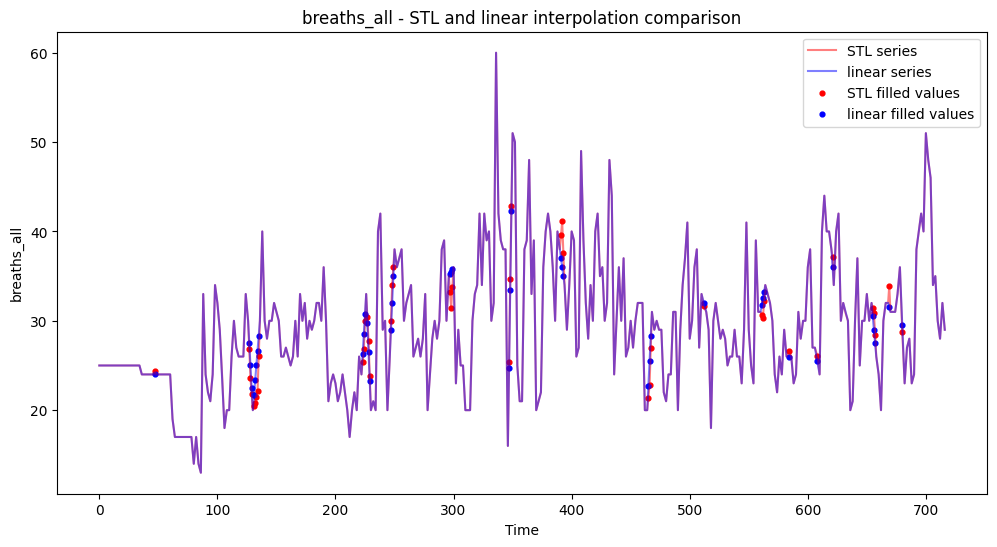

In [15]:
columns = list(df.columns)
columns.remove('date')

df_to_interpolate = df.set_index('date')
df_to_interpolate = df_to_interpolate.resample('30min').asfreq()
df_to_interpolate.reset_index(inplace=True)

for param in columns:
    dm = DecompositionMonster(param, df_to_interpolate=df_to_interpolate)
    dm.decompose(period=48)
    dm.stl_interpolate()
    dm.comparison_plot_both()
    # dm.comparison_plot_stl_only()
    df_to_interpolate_updated = dm.df_stl_int
    df_to_interpolate = df_to_interpolate_updated
  

Once I interpolated the data I rounded achieved values to reflect the accuracy of original data (e.g. accuracy of pulse records was 5 units). I used data interpolated using seasonal decomposition for further processing.

In [16]:
def round_to_5_or_0_digit(num):
    return 5 * round(num/5)

In [17]:
df_stl_int = df_to_interpolate_updated
df_stl_int.set_index('date', inplace=True)
df_stl_int = df_stl_int.resample('h').asfreq()
df_stl_int.reset_index(inplace=True)
df_stl_int = df_stl_int.round({
    'saturation_pct': 0,
    'CVP_average': 0,
    'breaths_forced': 0,
    'breaths_all': 0})
for param in ['pulse', 'RR_systolic', 'RR_diastolic']:
    df_stl_int[param] = df_stl_int[param].apply(round_to_5_or_0_digit)

In [18]:
df_stl_int.head()

,date,pulse,RR_systolic,RR_diastolic,saturation_pct,CVP_average,breaths_forced,breaths_all
0,2023-11-13 14:00:00,125,65,40,100.0,23.0,25.0,25.0
1,2023-11-13 15:00:00,130,90,50,100.0,20.0,25.0,25.0
2,2023-11-13 16:00:00,145,60,35,98.0,17.0,25.0,25.0
3,2023-11-13 17:00:00,140,55,45,97.0,18.0,25.0,25.0
4,2023-11-13 18:00:00,140,70,45,97.0,18.0,25.0,25.0


In [19]:
df_stl_int.to_csv('../../data/df_stl_interpolated.csv', index=False)